# Adaptive Background Model

Implementation of the adaptive background algorithm on a sequence of frames

In [1]:
import numpy as np
import os
import imageio.v3 as iio
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from types import NoneType

In [2]:
class AdaptiveBG:
    def __init__(self, base_dir, grayscale = True, alpha = 0.1, threshold=10):
        """
        Params:
        =======
            * base_dir : Base Directory containing the frame sequence.
            * alpha : Blending factor
            * threshold : threshold for difference in pixels
        returns:
        ========
            * AdaptiveBG Object
        """
        self.base_dir = base_dir
        self.__alpha = alpha
        assert self.__alpha <= 1
        
        self.threshold = threshold
        
        # Create & Store the figure to be updated
        self.fig, self.axes, self.axes_ims = None, None, list()
        if grayscale == True:
            self.cmap = 'gray'
        else:
            self.cmap = "viridis"
        self.files = sorted(os.listdir(base_dir))
        self.frames = None
        plt.ion() # Enable Interactive Mode
        self.__background_model = None
    
    def __init_plot(self)->None:
        """
            Helper function initializing the plot displaying the frames
        """
        self.fig, self.axes = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 4))
        plt.setp(self.axes.flat, xticks = [], yticks = [])
        for i, ax in enumerate(self.axes.flat):
            self.axes_ims.append(ax.imshow(np.zeros(self.frames[0].shape), cmap = self.cmap, vmin=0, vmax=255))
        self.fig.canvas.draw()
        display(self.fig, clear=True)
    
    def __update_plot(self, image_arr, labels)->None:
        """
            Function to update the plot with new frames/ images
        """
        if(len(self.axes.flat)!=len(image_arr)):
            raise Exception("Plot Axes and Image Array don't conform.")
        if len(labels) != len(image_arr):
            raise Exception("Images & Labels not in equal sizes")
        for i, ax in enumerate(self.axes.flat):
            self.axes_ims[i].set_data(image_arr[i])
            ax.set_title(labels[i])
        
        self.fig.suptitle(f'Adaptive Background Subtraction, Blending Factor: {self.__alpha}, Threshold: {self.threshold}', fontsize=14)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        display(self.fig, clear=True)
    
    def __get_frames(self):
        """
            Function to generate the frames from the provided os directory
        """
        frames = []
        print("Generating Frames...")
        for file in self.files:
            frame = iio.imread(self.base_dir+file)
            if self.cmap == 'gray':
                frame = np.dot(frame, [0.2989, 0.5870, 0.1140])
                frame = np.round(frame).astype(np.float16)
            frames.append(frame.astype(np.float16))
        return tuple(frames)
    
    def __update_background(self, latest_frame):
        """
            Helper function to update the background model
        """
        if type(self.__background_model) == NoneType:
            raise Exception("Background model not initialized")
        
        # Blend the background model
        self.__background_model = self.__background_model*(1-self.__alpha) + self.__alpha*latest_frame
    
    def __apply_threshold(self, *args):
        """
            Apply the threshold function
        """
        res = []
        for arg in args:
            arg[arg<self.threshold] = 0
            arg[arg!=0] = 255
            res.append(arg)
        return res
    
    def run(self):
        # Get the frames
        self.frames = self.__get_frames()
        zeros = np.zeros(self.frames[0].shape)

        self.__background_model = self.frames[0]
        
        # Initialize the plot
        self.__init_plot()

        for idx, frame in enumerate(self.frames[1:]):
            labels = [f"Current Frame (idx={idx})", "Background Model", "Tracking Frame", "Masked Frame"]
            diff = np.abs(frame-self.__background_model)
            tracked_frame = self.__apply_threshold(diff)[0]
            mask = np.any(tracked_frame, axis=2)
            masked_frame = np.copy(frame)
            masked_frame[mask,:] = [255,0,0]
            tracked_frame = tracked_frame.astype(np.uint8)
            tracked_frame[tracked_frame!=0]=255
            img_arr = [frame.astype(np.uint8), self.__background_model.astype(np.uint8), tracked_frame, masked_frame.astype(np.uint8)]
            self.__update_background(frame)
            try:
                self.__update_plot(img_arr, labels)
            except Exception as e:
                raise(e)
        clear_output()

In [3]:
model = AdaptiveBG(base_dir="data/frame sequence/", grayscale=False, threshold=25, alpha=0.3)

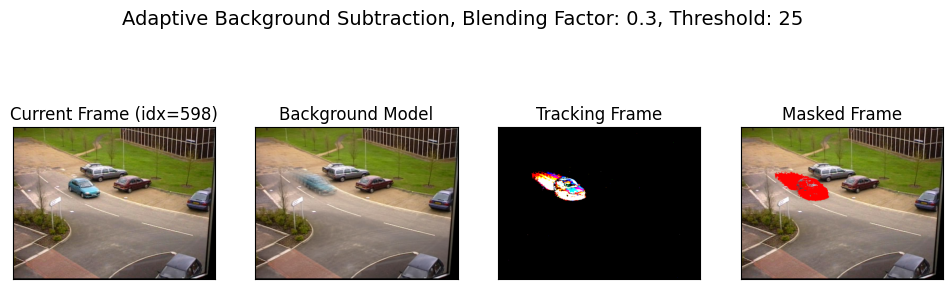

In [4]:
model.run()